Author: Ohm Jariwala

# Value at Risk and Esimated Shortfall Modeling : Parametric and Monte Carlo Approaches 

In [1]:
import yfinance as yf
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

start= dt.datetime(2019,1,1)
end= dt.datetime.now()

# List of sector ETFs
tickers = ["XLE", "XLB", "XLI", "XLY", "XLP", "XLV", "XLF", "SMH"]

# Equal weights for each sector (assumed equal weighting for portfolio)
n_tickers = len(tickers)
weights = np.ones(n_tickers) / n_tickers   # e.g., [0.125, 0.125, ..., 0.125]

df_data = yf.download(tickers, start= start, end=end, interval="1d", auto_adjust=True)["Close"]

df_returns = df_data.pct_change().dropna()

# Calculate portfolio returns
df_returns["Portfolio"] = df_returns.dot(weights)

print(f"Number of daily return observations: {df_returns.shape[0]}")

[*********************100%%**********************]  8 of 8 completed

Number of daily return observations: 1507


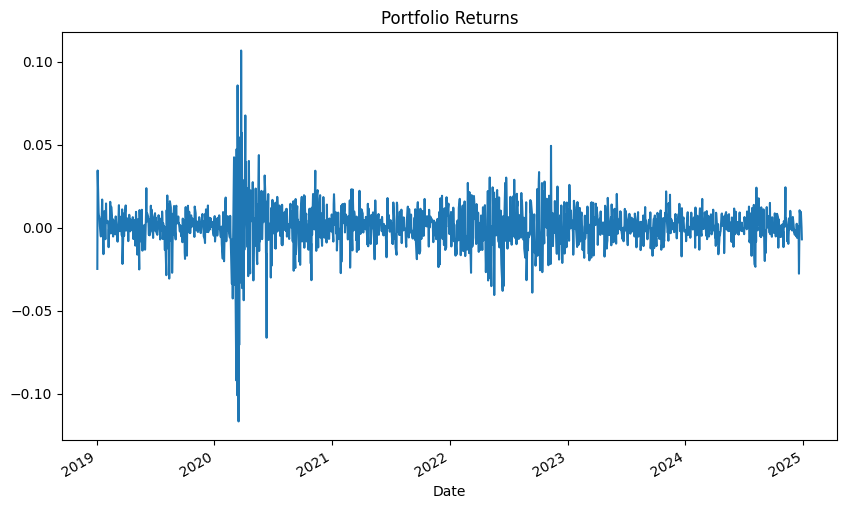

In [2]:
#Plot portfolio returns
plt.figure(figsize=(10, 6))
df_returns["Portfolio"].plot(title="Portfolio Returns")
plt.show()

Parametric VaR and ES

In [3]:
alpha = 0.95

#Mean vector and covariance matrix to calculate portfolio mean and variance
mean_vector = df_returns[tickers].mean()
cov_matrix = df_returns[tickers].cov()

port_mean = weights @ mean_vector
port_var  = weights @ cov_matrix @ weights
port_std  = np.sqrt(port_var)

z_alpha = norm.ppf(alpha)

#Parametric VaR (assuming daily returns are ~ normal)
param_var_95 = z_alpha * port_std - port_mean

#Parametric ES 
phi_z = norm.pdf(z_alpha)
param_es_95 = (phi_z / (1 - alpha)) * port_std - port_mean

print("======== Parametric VaR/ES (95%) ========")
print(f"Portfolio Mean Daily Return:  {port_mean:.5f}")
print(f"Portfolio Vol (std dev):  {port_std:.5f}")
print(f"Parametric VaR (95%):  {param_var_95:.5f}")
print(f"Parametric ES (95%):  {param_es_95:.5f}")

======== Parametric VaR/ES (95%) ========
Portfolio Mean Daily Return:  0.00069
Portfolio Vol (std dev):  0.01293
Parametric VaR (95%):  0.02057
Parametric ES (95%):  0.02597


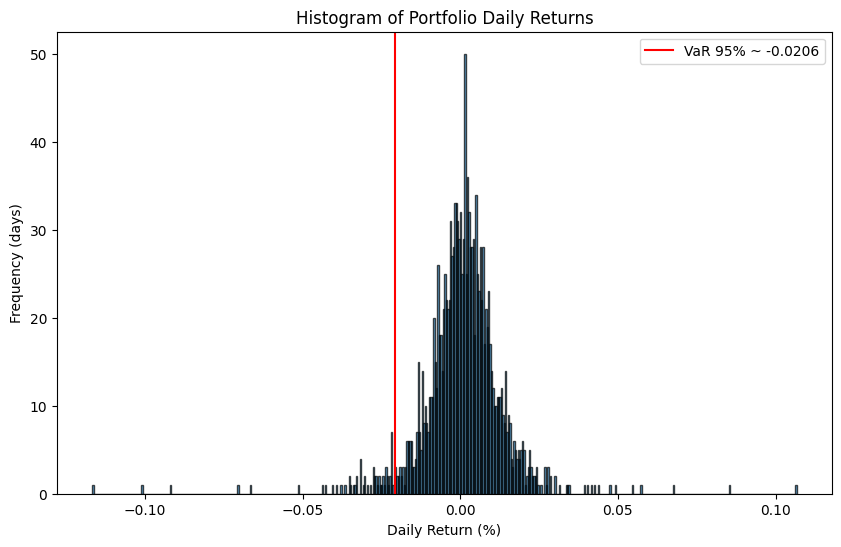

In [4]:
# HISTOGRAM OF PORTFOLIO RETURNS
portfolio_returns = df_returns["Portfolio"].dropna()

plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=500, edgecolor='k', alpha=0.7)
plt.title("Histogram of Portfolio Daily Returns")

# Draw a vertical line for the Parametric VaR
var_line = -param_var_95  # If you want to show VaR as a negative return threshold
plt.axvline(var_line, color='r', linestyle='-', label=f"VaR 95% ~ {var_line:.4f}")

plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency (days)")
plt.legend()
plt.show()

Monte Carlo VaR and ES

In [5]:
num_sims = 10000  

# Extract the correlation structure via Cholesky or np.random.multivariate_normal
simulated_returns = np.random.multivariate_normal(mean_vector, cov_matrix, size=num_sims)

# Portfolio return for each simulation --> Weighted sum across columns
sim_port_returns = simulated_returns @ weights

# Sort the simulated portfolio returns
sim_port_sorted = np.sort(sim_port_returns)

var_index = int((1 - alpha) * num_sims)
montecarlo_var_95 = -sim_port_sorted[var_index] # negative sign to convert to loss

tail_losses = sim_port_sorted[:var_index]  # worst returns

if len(tail_losses) > 0:
    montecarlo_es_95 = -tail_losses.mean()

else:
    montecarlo_es_95 = -sim_port_sorted[0]

print("\n======== Monte Carlo VaR/ES (95%) ========")
print(f"Monte Carlo VaR (95%): {montecarlo_var_95:.5f}")
print(f"Monte Carlo ES (95%):  {montecarlo_es_95:.5f}")


======== Monte Carlo VaR/ES (95%) ========
Monte Carlo VaR (95%): 0.02026
Monte Carlo ES (95%):  0.02532


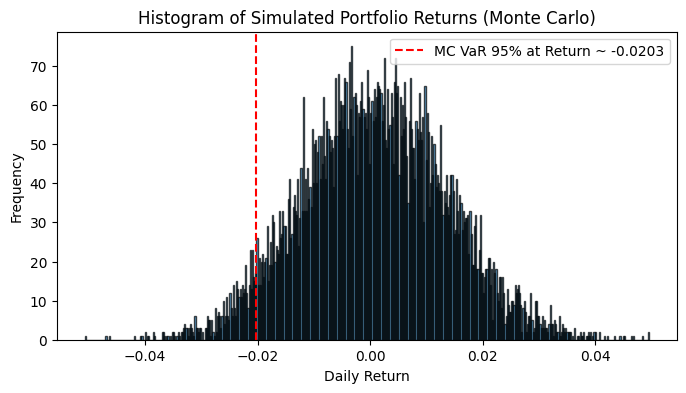

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(sim_port_returns, bins=500, edgecolor='k', alpha=0.7)
plt.title("Histogram of Simulated Portfolio Returns (Monte Carlo)")

threshold_return = sim_port_sorted[var_index]  # This is a negative return value
plt.axvline(threshold_return, color='red', linestyle='--',label=f"MC VaR 95% at Return ~ {threshold_return:.4f}")

plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

GARCH Based VaR and ES

In [7]:
garch_data = portfolio_returns.dropna()  # 1D Series of daily returns

garch_model = arch_model(garch_data, vol='Garch', p=1, q=1, dist='normal', rescale=False)
res = garch_model.fit(update_freq=0, disp="off")  # MLE fit

#1 day ahead forecast
rolling_forecasts = res.forecast(horizon=1, start=len(garch_data)//2, reindex=False) #starts halfway through the data

# Extract the forecasted variance
var_pred = rolling_forecasts.variance.values[:, 0] 
std_pred = np.sqrt(var_pred)  # predicted vol (std dev)

# Dates for the forecasted variance
forecast_dates = rolling_forecasts.variance.index


# Compute VaR & ES from GARCH Forecast

alpha_garch = 0.95
z_alpha_garch = norm.ppf(alpha_garch)
phi_z_garch = norm.pdf(z_alpha_garch)

# Arrays to store daily VaR & ES
garch_var = z_alpha_garch * std_pred  # ignoring the mean, sign convention => these are losses
garch_es = (phi_z_garch / (1 - alpha_garch)) * std_pred

# Convert to pandas Series for convenience
garch_var_series = pd.Series(garch_var, index=forecast_dates, name="GARCH_VaR_95")
garch_es_series  = pd.Series(garch_es,  index=forecast_dates, name="GARCH_ES_95")

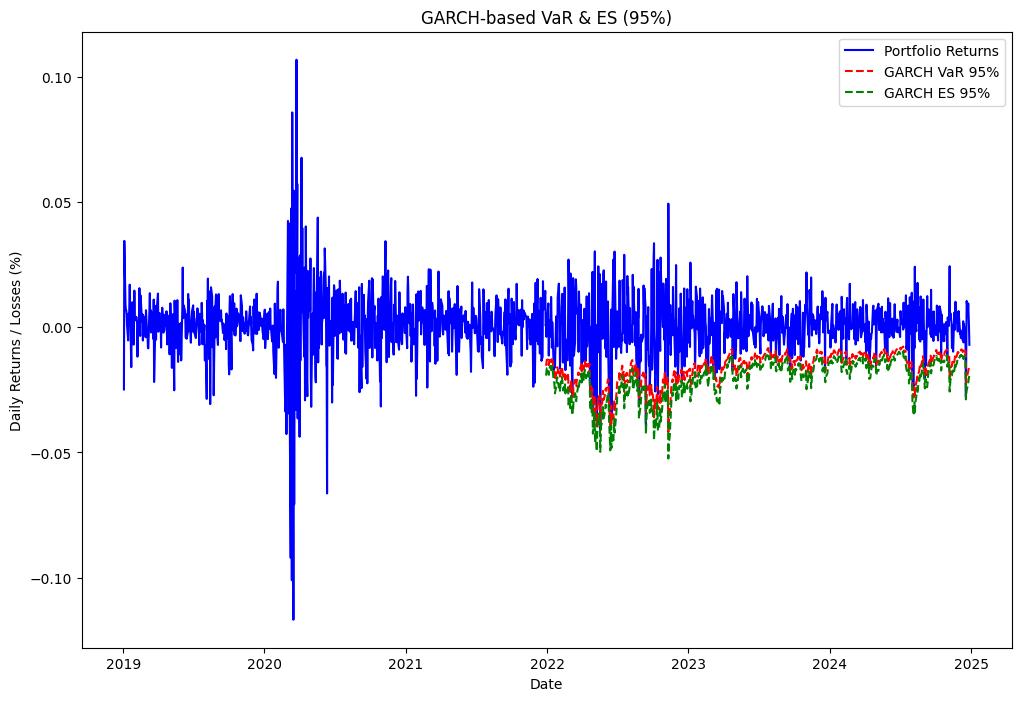

In [8]:
plt.figure(figsize=(12,8))
plt.plot(garch_data.index, garch_data, 'b-',label="Portfolio Returns")
plt.plot(garch_var_series.index, -garch_var_series, 'r--', label="GARCH VaR 95%")
plt.plot(garch_es_series.index,  -garch_es_series,  'g--', label="GARCH ES 95%")

plt.title("GARCH-based VaR & ES (95%)")
plt.xlabel("Date")
plt.ylabel("Daily Returns / Losses (%)")
plt.legend()
plt.show()

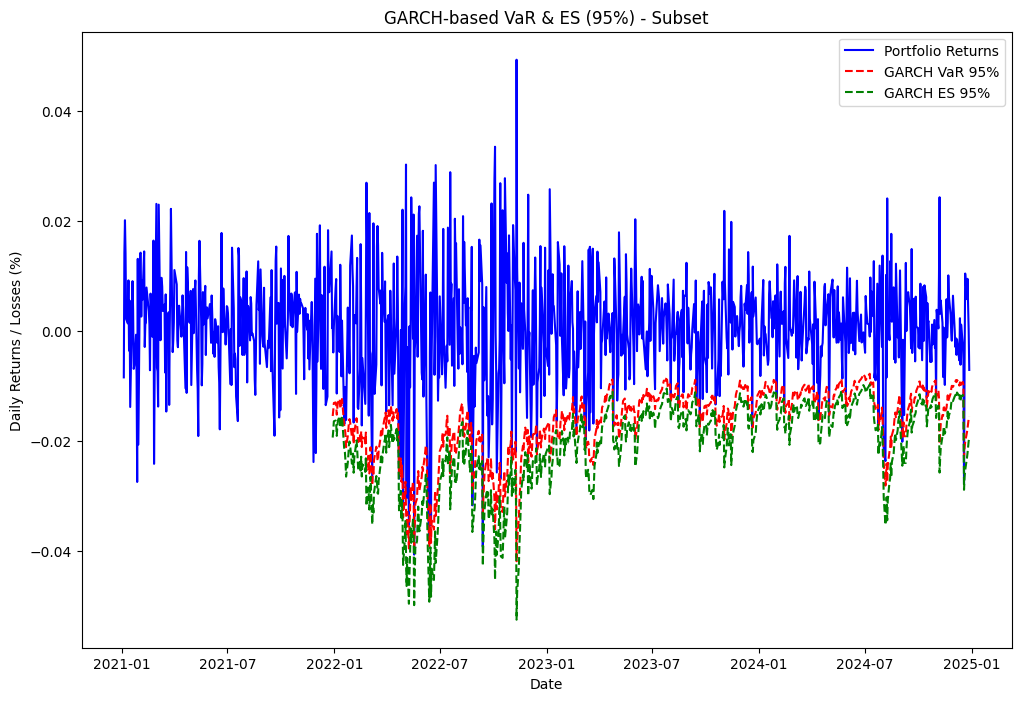

In [9]:
#Zoom in on a subset of the data
start_date = "2021-01-01"

plt.figure(figsize=(12, 8))
plt.plot(garch_data.loc[start_date:].index, garch_data.loc[start_date:], 'b-', label="Portfolio Returns")
plt.plot(garch_var_series.loc[start_date:].index,  -garch_var_series.loc[start_date:],  'r--', label="GARCH VaR 95%")
plt.plot(garch_es_series.loc[start_date:].index,   -garch_es_series.loc[start_date:],   'g--', label="GARCH ES 95%")

plt.title("GARCH-based VaR & ES (95%) - Subset")
plt.xlabel("Date")
plt.ylabel("Daily Returns / Losses (%)")
plt.legend()
plt.show()
